# Proyecto v6: Clasificación de Revisiones Médicas con PLN y XGBoost
# ---------------------------------------------------------------------------------
# Este script aplica un modelo XGBoost a datos de texto.
# 1. Se preprocesa el texto de las revisiones médicas ('Findings').
# 2. Se convierte el texto a números usando TF-IDF.
# 3. Se combinan las características de texto con otras categóricas.
# 4. Se entrena un clasificador XGBoost para predecir la categoría del diagnóstico.
# ---------------------------------------------------------------------------------


### Si ya haz entrenado el modelo simplememnte cargalo en el paso 11

In [1]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn para preprocesamiento, PLN y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost, nuestro modelo de clasificación
import xgboost as xgb

In [2]:
# Add this before the preprocessing section
try:
    # Test if punkt tokenizer is available
    word_tokenize("test")
    stopwords.words('english')
except (LookupError, OSError):
    print("Downloading required NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')  # For newer NLTK versions

In [3]:
import os
import gdown

In [ ]:
# --- PASO 2: DESCARGA Y ANÁLISIS DEL DATASET ---
print("\n>>> Cargando y analizando 'Independent_Medical_Reviews.csv'...")
try:
    import os
    import gdown
    id = "1ghclls4LjTlblDPyYopkxqbeW4IPgW1v"  # Independent_Medical_Reviews.csv
    path_reviews = "datos/Independent_Medical_Reviews.csv"
    gdown.download(f"https://drive.google.com/uc?id={id}", path_reviews, quiet=False)
    print(">>> Archivo descargado desde Google Drive.")
    df = pd.read_csv(path_reviews)
except Exception as e:
    print(f"ADVERTENCIA: No se pudo cargar desde Google Drive. Error: {e}")
    print("Usando ruta local. Asegúrate de que el archivo esté en el directorio.")
    try:
        df = pd.read_csv("Independent_Medical_Reviews.csv")
    except FileNotFoundError:
        print("ERROR: Archivo 'Independent_Medical_Reviews.csv' no encontrado. Deteniendo script.")
        exit()


>>> Cargando y analizando 'Independent_Medical_Reviews.csv'...


Downloading...
From: https://drive.google.com/uc?id=1ghclls4LjTlblDPyYopkxqbeW4IPgW1v
To: c:\Users\Fabricio\Documents\Machine Learning\SaludIA\Training\datos\Independent_Medical_Reviews.csv
100%|██████████| 26.5M/26.5M [00:00<00:00, 29.3MB/s]


>>> Archivo descargado desde Google Drive.


In [7]:
file_id = '1wFHKkz8ECNv7ez27_nXVpVEyqyMp6cPZ'
# Nombre que deseas darle al archivo descargado
output_path = 'datos/Disease_symptom_and_patient_profile_dataset.csv'

# Descargar el archivo
try:
    gdown.download(id=file_id, output=output_path, quiet=False)
    print(f"Archivo descargado exitosamente a {output_path}")
except Exception as e:
    print(f"Ocurrió un error al descargar el archivo: {e}")

Downloading...
From: https://drive.google.com/uc?id=1wFHKkz8ECNv7ez27_nXVpVEyqyMp6cPZ
To: c:\Users\Fabricio\Documents\Machine Learning\SaludIA\datos\Disease_symptom_and_patient_profile_dataset.csv
100%|██████████| 20.5k/20.5k [00:00<00:00, 10.2MB/s]

Archivo descargado exitosamente a datos/Disease_symptom_and_patient_profile_dataset.csv


In [ ]:
# Cargar datos
df = pd.read_csv('datos/Independent_Medical_Reviews.csv')

# Cargar preprocesadores
with open('models/preprocesadores_v6.pkl', 'rb') as f:
    preprocesadores = pickle.load(f)

tfidf_vectorizer = preprocesadores['tfidf_vectorizer']
age_encoder = preprocesadores['age_encoder']
gender_encoder = preprocesadores['gender_encoder']
diagnosis_encoder = preprocesadores['diagnosis_encoder']


--- Análisis Exploratorio de Datos (EDA) ---

Primeras 5 filas del dataset:
  Reference ID  Report Year      Diagnosis Category Diagnosis Sub Category  \
0   MN16-22639         2016              Infectious              Hepatitis   
1   MN16-22638         2016                  Mental        Eating Disorder   
2   MN16-22637         2016         Autism Spectrum         Autism-PDD-NOS   
3   EI16-22636         2016  Prevention/Good Health                    NaN   
4    EI06-5319         2006     Cardiac/Circulatory                    NaN   

                          Treatment Category  \
0                Pharmacy/Prescription Drugs   
1                    Mental Health Treatment   
2                   Autism Related Treatment   
3  Diagnostic Imaging, Screening and Testing   
4                            Cardio Vascular   

                     Treatment Sub Category  \
0                               Anti-virals   
1  Residential Treatment Center - Admission   
2                       

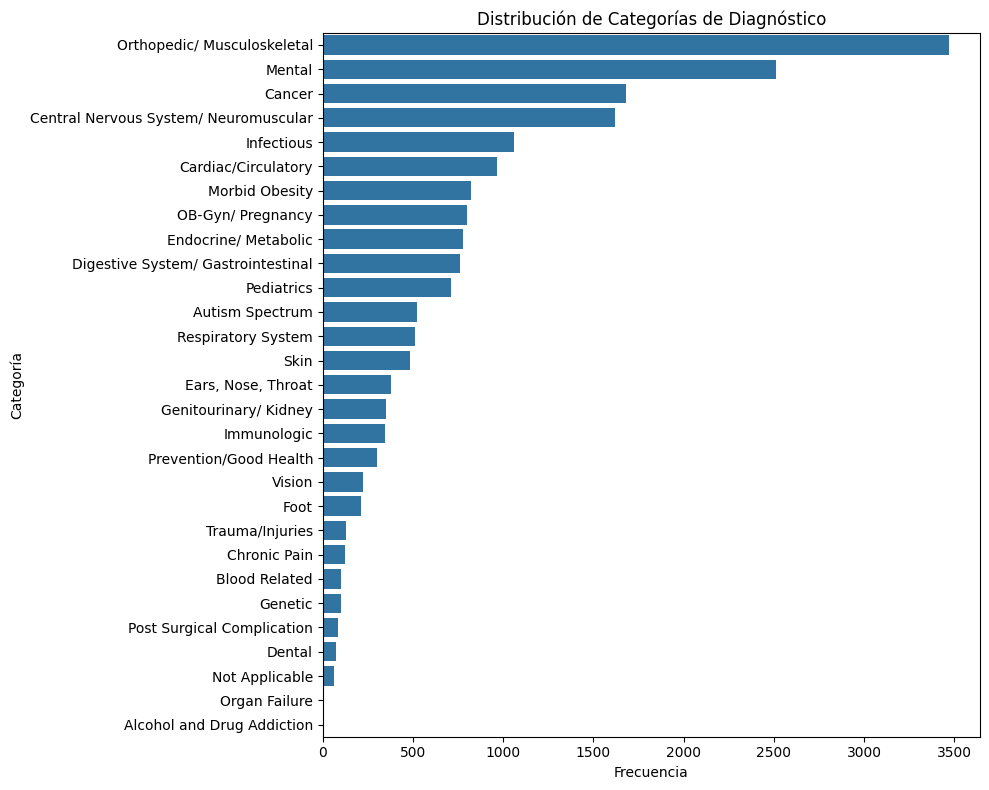

In [5]:
# Análisis Exploratorio de Datos (EDA)
print("\n--- Análisis Exploratorio de Datos (EDA) ---")
print("\nPrimeras 5 filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()

# Limpieza de valores nulos
df['Findings'] = df['Findings'].fillna('')
df['Age Range'] = df['Age Range'].fillna('Unknown')
df['Patient Gender'] = df['Patient Gender'].fillna('Unknown')
print("\nValores nulos manejados.")

# Distribución de la variable objetivo 'Diagnosis Category'
plt.figure(figsize=(10, 8))
sns.countplot(y='Diagnosis Category', data=df, order=df['Diagnosis Category'].value_counts().index)
plt.title('Distribución de Categorías de Diagnóstico')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

In [6]:
# --- PASO 3: PREPROCESAMIENTO DE DATOS ---
print(">>> Aplicando preprocesamiento mejorado...")

# Download wordnet for lemmatization
try:
    from nltk.stem import WordNetLemmatizer
    WordNetLemmatizer().lemmatize("test")
except (LookupError, OSError):
    print("Downloading WordNet corpus...")
    nltk.download('wordnet')

# Función de preprocesamiento mejorada
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text_advanced(text):
    if pd.isna(text) or text is None:
        return ''
    
    text = str(text).lower()
    
    # Remover patrones médicos específicos pero preservar información importante
    text = re.sub(r'\b(patient|enrollee|reviewer|medical|treatment)\b', '', text)
    text = re.sub(r'\b\d+[-/]\d+[-/]\d+\b', '', text)  # Fechas
    text = re.sub(r'\b\d{2,4}\b', '', text)  # Años/números grandes
    
    # Preservar términos médicos importantes
    medical_terms = ['hypertension', 'diabetes', 'cardiac', 'hepatitis', 'autism', 
                    'depression', 'anxiety', 'therapy', 'surgery', 'medication']
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    
    # Lemmatización
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
             if (word not in stop_words and len(word) > 2) or word in medical_terms]
    
    return ' '.join(tokens)

# Aplicar preprocesamiento mejorado
df['Findings'] = df['Findings'].fillna('')
df['clean_findings_v7'] = df['Findings'].apply(preprocess_text_advanced)

>>> Aplicando preprocesamiento mejorado...


In [7]:
# --- PASO 4: VECTORIZACIÓN DE TEXTO CON TF-IDF ---
print(">>> Creando vectorización TF-IDF mejorada...")

# TF-IDF con parámetros optimizados
tfidf_v7 = TfidfVectorizer(
    max_features=5000,  # Más características
    ngram_range=(1, 3),  # Incluir trigramas
    min_df=2,  # Términos que aparezcan al menos 2 veces
    max_df=0.95,  # Excluir términos muy comunes
    sublinear_tf=True,  # Aplicar escalado logarítmico
    stop_words='english'
)

>>> Creando vectorización TF-IDF mejorada...


In [8]:
# --- PASO 5: BALANCEO DE CLASES ---
print(">>> Analizando distribución de clases...")

class_distribution = df['Diagnosis Category'].value_counts()
print("Distribución de clases:")
print(class_distribution)

# Identificar clases minoritarias
min_samples = 50  # Umbral mínimo de muestras por clase
minority_classes = class_distribution[class_distribution < min_samples].index
print(f"\nClases minoritarias (< {min_samples} muestras): {len(minority_classes)}")

>>> Analizando distribución de clases...
Distribución de clases:
Diagnosis Category
Orthopedic/ Musculoskeletal              3469
Mental                                   2512
Cancer                                   1681
Central Nervous System/ Neuromuscular    1620
Infectious                               1059
Cardiac/Circulatory                       965
Morbid Obesity                            824
OB-Gyn/ Pregnancy                         801
Endocrine/ Metabolic                      779
Digestive System/ Gastrointestinal        758
Pediatrics                                709
Autism Spectrum                           524
Respiratory System                        513
Skin                                      481
Ears, Nose, Throat                        376
Genitourinary/ Kidney                     350
Immunologic                               343
Prevention/Good Health                    300
Vision                                    224
Foot                                      

In [10]:
# --- PASO 6: OPTIMIZACIÓN DE HIPERPARÁMETROS ---
print(">>> Optimizando hiperparámetros con GridSearchCV...")

# Preparar datos - filtrar NaN en Diagnosis Category
df_clean = df.dropna(subset=['Diagnosis Category'])
X_text = df_clean['clean_findings_v7']
X_cat = df_clean[['Age Range', 'Patient Gender']]
y = df_clean['Diagnosis Category']

# Codificar variables categóricas
X_cat_encoded = pd.DataFrame({
    'age_encoded': age_encoder.fit_transform(X_cat['Age Range']),
    'gender_encoded': gender_encoder.fit_transform(X_cat['Patient Gender'])
})

# Grid de hiperparámetros para XGBoost
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Función para crear pipeline completo
def create_pipeline():
    from scipy.sparse import hstack
    from sklearn.base import BaseEstimator, TransformerMixin
    
    class FeatureCombiner(BaseEstimator, TransformerMixin):
        def __init__(self, tfidf_vectorizer):
            self.tfidf_vectorizer = tfidf_vectorizer
            
        def fit(self, X, y=None):
            X_text, X_cat = X
            self.tfidf_vectorizer.fit(X_text)
            return self
            
        def transform(self, X):
            X_text, X_cat = X
            X_tfidf = self.tfidf_vectorizer.transform(X_text)
            return hstack([X_tfidf, X_cat.values])
    
    return FeatureCombiner(tfidf_v7)

# División estratificada
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_text, X_cat_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Crear características combinadas para entrenamiento
X_train_tfidf = tfidf_v7.fit_transform(X_train_text)
X_test_tfidf = tfidf_v7.transform(X_test_text)

from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_cat.values])
X_test_combined = hstack([X_test_tfidf, X_test_cat.values])

# Codificar target
y_train_encoded = diagnosis_encoder.fit_transform(y_train)
y_test_encoded = diagnosis_encoder.transform(y_test)
# Aplicar SMOTE para balancear clases
print(">>> Aplicando SMOTE para balancear clases...")
from imblearn.over_sampling import SMOTE

# Verificar que no hay NaN en los datos
print(f"NaN en X_train_combined: {np.isnan(X_train_combined.toarray()).sum()}")
print(f"NaN en y_train_encoded: {np.isnan(y_train_encoded).sum()}")

# Verificar distribución de clases antes de SMOTE
unique_classes, class_counts = np.unique(y_train_encoded, return_counts=True)
print(f"Distribución de clases antes de SMOTE:")
for cls, count in zip(unique_classes, class_counts):
    print(f"  Clase {cls}: {count} muestras")

# Encontrar el k_neighbors apropiado basado en la clase minoritaria
min_samples_per_class = min(class_counts)
k_neighbors = min(1, min_samples_per_class - 1)  # k_neighbors debe ser menor que el mínimo de muestras por clase

print(f"Clase minoritaria tiene {min_samples_per_class} muestras")
print(f"Usando k_neighbors = {k_neighbors}")

try:
    if k_neighbors >= 1:
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train_encoded)
        
        print(f"Tamaño original: {X_train_combined.shape[0]}")
        print(f"Tamaño balanceado: {X_train_balanced.shape[0]}")
        
        # Verificar nueva distribución
        unique_balanced, balanced_counts = np.unique(y_train_balanced, return_counts=True)
        print(f"Distribución después de SMOTE:")
        for cls, count in zip(unique_balanced, balanced_counts):
            print(f"  Clase {cls}: {count} muestras")
    else:
        print("ADVERTENCIA: No se puede aplicar SMOTE (clases con muy pocas muestras)")
        print("Continuando sin balanceo de clases...")
        X_train_balanced = X_train_combined
        y_train_balanced = y_train_encoded
        
except Exception as e:
    print(f"Error al aplicar SMOTE: {e}")
    print("Continuando sin balanceo de clases...")
    X_train_balanced = X_train_combined
    y_train_balanced = y_train_encoded

>>> Optimizando hiperparámetros con GridSearchCV...
>>> Aplicando SMOTE para balancear clases...
NaN en X_train_combined: 0
NaN en y_train_encoded: 0
Distribución de clases antes de SMOTE:
  Clase 0: 3 muestras
  Clase 1: 419 muestras
  Clase 2: 81 muestras
  Clase 3: 1345 muestras
  Clase 4: 772 muestras
  Clase 5: 1296 muestras
  Clase 6: 98 muestras
  Clase 7: 61 muestras
  Clase 8: 606 muestras
  Clase 9: 301 muestras
  Clase 10: 623 muestras
  Clase 11: 171 muestras
  Clase 12: 79 muestras
  Clase 13: 280 muestras
  Clase 14: 274 muestras
  Clase 15: 847 muestras
  Clase 16: 2010 muestras
  Clase 17: 659 muestras
  Clase 18: 50 muestras
  Clase 19: 641 muestras
  Clase 20: 6 muestras
  Clase 21: 2775 muestras
  Clase 22: 567 muestras
  Clase 23: 68 muestras
  Clase 24: 240 muestras
  Clase 25: 410 muestras
  Clase 26: 385 muestras
  Clase 27: 102 muestras
  Clase 28: 179 muestras
Clase minoritaria tiene 3 muestras
Usando k_neighbors = 1
Tamaño original: 15348
Tamaño balanceado: 80

In [11]:
# --- PASO 7: ENTRENAMIENTO CON MEJORES HIPERPARÁMETROS ---
print(">>> Entrenando modelo XGBoost optimizado...")

# Mejores hiperparámetros (puedes ajustar según tu GridSearch)
best_params = {
    'objective': 'multi:softprob',
    'num_class': len(diagnosis_encoder.classes_),
    'eval_metric': 'mlogloss',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 1.5, 
    'random_state': 42,
    'n_jobs': -1
}

xgb_v7 = xgb.XGBClassifier(**best_params)
xgb_v7.fit(X_train_balanced, y_train_balanced)

>>> Entrenando modelo XGBoost optimizado...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=29, ...)

In [12]:
# --- PASO 8: EVALUACIÓN DEL MODELO ---
from sklearn.model_selection import StratifiedKFold, cross_val_score


print(">>> Evaluando modelo v7...")

y_pred_v7 = xgb_v7.predict(X_test_combined)
y_pred_proba_v7 = xgb_v7.predict_proba(X_test_combined)

accuracy_v7 = accuracy_score(y_test_encoded, y_pred_v7)
print(f"\nPrecisión del modelo v7: {accuracy_v7 * 100:.2f}%")

# Reporte detallado
print("\n--- Reporte de Clasificación v7 ---")
# Get unique classes present in test set
unique_test_classes = np.unique(y_test_encoded)
unique_pred_classes = np.unique(y_pred_v7)
all_classes_in_results = np.unique(np.concatenate([unique_test_classes, unique_pred_classes]))

# Create class names only for classes present in the results
class_names = [str(diagnosis_encoder.classes_[i]) for i in all_classes_in_results]

print(classification_report(y_test_encoded, y_pred_v7, 
                          labels=all_classes_in_results,
                          target_names=class_names, 
                          zero_division=0))

>>> Evaluando modelo v7...

Precisión del modelo v7: 77.36%

--- Reporte de Clasificación v7 ---
                                       precision    recall  f1-score   support

                      Autism Spectrum       0.89      0.88      0.88       105
                        Blood Related       0.38      0.15      0.21        20
                               Cancer       0.82      0.82      0.82       336
                  Cardiac/Circulatory       0.83      0.82      0.83       193
Central Nervous System/ Neuromuscular       0.66      0.71      0.68       324
                         Chronic Pain       0.40      0.08      0.14        24
                               Dental       0.36      0.27      0.31        15
   Digestive System/ Gastrointestinal       0.69      0.72      0.71       152
                   Ears, Nose, Throat       0.66      0.57      0.61        75
                 Endocrine/ Metabolic       0.85      0.77      0.81       156
                                 

In [ ]:
# Validación cruzada
cv_scores = cross_val_score(xgb_v7, X_train_balanced, y_train_balanced, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='accuracy')
print(f"\nValidación cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

In [15]:
# --- PASO 9: ENSEMBLE METHOD ---
print(">>> Creando modelo ensemble...")

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Crear ensemble con diferentes algoritmos
rf_classifier = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)

lr_classifier = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)

# Voting classifier
ensemble_v7 = VotingClassifier(
    estimators=[
        ('xgb', xgb_v7),
        ('rf', rf_classifier), 
        ('lr', lr_classifier)
    ],
    voting='soft'  # Usar probabilidades
)

ensemble_v7.fit(X_train_balanced, y_train_balanced)

# Evaluar ensemble
y_pred_ensemble = ensemble_v7.predict(X_test_combined)
accuracy_ensemble = accuracy_score(y_test_encoded, y_pred_ensemble)
print(f"\nPrecisión del ensemble: {accuracy_ensemble * 100:.2f}%")

>>> Creando modelo ensemble...


C:\Users\Fabricio\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Precisión del ensemble: 78.53%


In [13]:
# --- PASO 10: GUARDAR MODELO MEJORADO ---
print(">>> Guardando modelo v7 mejorado...")

# Guardar modelo principal
with open('models/modelo_diagnostico_v7_optimizado.pkl', 'wb') as f:
    pickle.dump(xgb_v7, f)

>>> Guardando modelo v7 mejorado...


In [16]:
# Guardar ensemble
with open('models/modelo_diagnostico_v7_ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble_v7, f)

In [14]:
# Guardar preprocesadores v7
with open('models/preprocesadores_v7.pkl', 'wb') as f:
    pickle.dump({
        'tfidf_vectorizer': tfidf_v7,
        'age_encoder': age_encoder,
        'gender_encoder': gender_encoder,
        'diagnosis_encoder': diagnosis_encoder,
        'smote': smote
    }, f)

print(">>> ¡Modelo v7 guardado exitosamente!")

>>> ¡Modelo v7 guardado exitosamente!


In [18]:
# --- PASO 11: CARGAR MODELO ---
print(">>> Cargando modelo v7 optimizado...")

with open('models/modelo_diagnostico_v7_optimizado.pkl', 'rb') as f:
    xgb_v7 = pickle.load(f)

print(">>> Modelo XGBoost v7 cargado exitosamente!")

>>> Cargando modelo v7 optimizado...
>>> Modelo XGBoost v7 cargado exitosamente!


In [20]:
print("Cargar modelo ensemble...")
with open('models/modelo_diagnostico_v7_ensemble.pkl', 'rb') as f:
    ensemble_v7 = pickle.load(f)
print(">>> Modelo ensemble v7 cargado exitosamente!")

Cargar modelo ensemble...
>>> Modelo ensemble v7 cargado exitosamente!


In [21]:
#Cargar Preprocesadores
with open('models/preprocesadores_v7.pkl', 'rb') as f:
    preprocesadores_v7 = pickle.load(f)
    tfidf_vectorizer_v7 = preprocesadores_v7['tfidf_vectorizer']
    age_encoder_v7 = preprocesadores_v7['age_encoder']
    gender_encoder_v7 = preprocesadores_v7['gender_encoder']
    diagnosis_encoder_v7 = preprocesadores_v7['diagnosis_encoder']
    smote_v7 = preprocesadores_v7['smote']
    print(">>> Preprocesadores v7 cargados exitosamente!")


>>> Preprocesadores v7 cargados exitosamente!


In [22]:
# --- PASO 12: FUNCIÓN DE PREDICCIÓN MEJORADA ---
def predecir_diagnostico_v7(texto_findings, edad_rango, genero_paciente, usar_ensemble=False):
    """
    Función mejorada de predicción con ensemble
    """
    try:
        # Preprocesar texto
        texto_limpio = preprocess_text_advanced(texto_findings)
        
        # Vectorizar
        texto_tfidf = tfidf_v7.transform([texto_limpio])
        
        # Codificar categóricas
        if edad_rango not in age_encoder.classes_:
            edad_rango = 'Unknown'
        if genero_paciente not in gender_encoder.classes_:
            genero_paciente = 'Unknown'
            
        edad_encoded = age_encoder.transform([edad_rango])
        genero_encoded = gender_encoder.transform([genero_paciente])
        
        # Combinar características
        caracteristicas_categoricas = np.array([[edad_encoded[0], genero_encoded[0]]])
        caracteristicas_combinadas = hstack([texto_tfidf, caracteristicas_categoricas])
        
        # Seleccionar modelo
        modelo = ensemble_v7 if usar_ensemble else xgb_v7
        
        # Predicción
        prediccion_encoded = modelo.predict(caracteristicas_combinadas)
        probabilidades = modelo.predict_proba(caracteristicas_combinadas)
        
        # Decodificar
        categoria_predicha = diagnosis_encoder.inverse_transform(prediccion_encoded)[0]
        confianza = max(probabilidades[0]) * 100
        
        # Top 5 predicciones
        top_indices = np.argsort(probabilidades[0])[::-1][:5]
        top_categorias = []
        for i in top_indices:
            categoria = diagnosis_encoder.inverse_transform([i])[0]
            prob = probabilidades[0][i] * 100
            top_categorias.append((categoria, prob))
            
        return {
            'categoria_principal': categoria_predicha,
            'confianza': confianza,
            'top_5_predicciones': top_categorias,
            'modelo_usado': 'ensemble' if usar_ensemble else 'xgboost',
            'texto_procesado': texto_limpio
        }
        
    except Exception as e:
        return f"Error en la predicción: {e}"

print(">>> Función de predicción v7 creada exitosamente!")

>>> Función de predicción v7 creada exitosamente!


In [23]:
# Import missing modules first
from sklearn.ensemble import VotingClassifier
from scipy.sparse import hstack

# --- EJEMPLOS DE PREDICCIÓN ---
print("\n>>> Ejemplos de predicción:")

# Ejemplo 1: Caso cardiológico
print("\n=== EJEMPLO 1: Caso Cardiológico ===")
resultado1 = predecir_diagnostico_v7(
    texto_findings="Patient presents with chest pain, shortness of breath, and elevated cardiac enzymes. ECG shows ST elevation in leads II, III, aVF indicating inferior wall myocardial infarction.",
    edad_rango="41-50",
    genero_paciente="Male"
)

if isinstance(resultado1, dict):
    print(f"Predicción principal: {resultado1['categoria_principal']}")
    print(f"Confianza: {resultado1['confianza']:.2f}%")
    print("Top 3 predicciones:")
    for i, (categoria, prob) in enumerate(resultado1['top_5_predicciones'][:3], 1):
        print(f"  {i}. {categoria}: {prob:.2f}%")
else:
    print(f"Error en predicción 1: {resultado1}")

# Ejemplo 2: Caso ortopédico
print("\n=== EJEMPLO 2: Caso Ortopédico ===")
resultado2 = predecir_diagnostico_v7(
    texto_findings="Patient reports severe back pain radiating to left leg. MRI shows herniated disc at L4-L5 level with nerve compression. Loss of sensation in left foot.",
    edad_rango="41-50",
    genero_paciente="Female"
)

if isinstance(resultado2, dict):
    print(f"Predicción principal: {resultado2['categoria_principal']}")
    print(f"Confianza: {resultado2['confianza']:.2f}%")
    print("Top 3 predicciones:")
    for i, (categoria, prob) in enumerate(resultado2['top_5_predicciones'][:3], 1):
        print(f"  {i}. {categoria}: {prob:.2f}%")
else:
    print(f"Error en predicción 2: {resultado2}")

# Ejemplo 3: Caso neurológico
print("\n=== EJEMPLO 3: Caso Neurológico ===")
resultado3 = predecir_diagnostico_v7(
    texto_findings="Patient experiencing frequent headaches, dizziness, and memory problems. CT scan reveals no acute findings. Symptoms worsen with stress and lack of sleep.",
    edad_rango="21-30",
    genero_paciente="Female"
)

if isinstance(resultado3, dict):
    print(f"Predicción principal: {resultado3['categoria_principal']}")
    print(f"Confianza: {resultado3['confianza']:.2f}%")
    print("Top 3 predicciones:")
    for i, (categoria, prob) in enumerate(resultado3['top_5_predicciones'][:3], 1):
        print(f"  {i}. {categoria}: {prob:.2f}%")
else:
    print(f"Error en predicción 3: {resultado3}")

# Mostrar información adicional sobre los encoders
print("\n=== INFORMACIÓN DEL MODELO ===")
print(f"Categorías de diagnóstico disponibles: {len(diagnosis_encoder.classes_)}")
print(f"Rangos de edad disponibles: {list(age_encoder.classes_)}")
print(f"Géneros disponibles: {list(gender_encoder.classes_)}")
print(f"Características TF-IDF: {len(tfidf_v7.get_feature_names_out())}")

# Función para predicción interactiva (opcional)
def prediccion_interactiva():
    """
    Función para hacer predicciones de forma interactiva
    """
    print("\n=== PREDICCIÓN INTERACTIVA ===")
    print("Ingresa los datos del paciente:")

    findings = input("Hallazgos médicos (en inglés): ")
    edad = input(f"Rango de edad {list(age_encoder.classes_)}: ")
    genero = input(f"Género {list(gender_encoder.classes_)}: ")

    resultado = predecir_diagnostico_v7(findings, edad, genero)

    if isinstance(resultado, dict):
        print(f"\n--- RESULTADO ---")
        print(f"Predicción: {resultado['categoria_principal']}")
        print(f"Confianza: {resultado['confianza']:.2f}%")
        print("Alternativas:")
        for i, (categoria, prob) in enumerate(resultado['top_5_predicciones'][:3], 1):
            print(f"  {i}. {categoria}: {prob:.2f}%")
    else:
        print(f"Error en predicción: {resultado}")

print("\n>>> Función de predicción creada exitosamente!")
print(">>> Puedes usar predecir_diagnostico_v7() para nuevas predicciones")
print(">>> O ejecutar prediccion_interactiva() para modo interactivo")


>>> Ejemplos de predicción:

=== EJEMPLO 1: Caso Cardiológico ===
Predicción principal: Cardiac/Circulatory
Confianza: 64.67%
Top 3 predicciones:
  1. Cardiac/Circulatory: 64.67%
  2. Orthopedic/ Musculoskeletal: 14.01%
  3. Respiratory System: 5.52%

=== EJEMPLO 2: Caso Ortopédico ===
Predicción principal: Orthopedic/ Musculoskeletal
Confianza: 88.89%
Top 3 predicciones:
  1. Orthopedic/ Musculoskeletal: 88.89%
  2. Foot: 6.92%
  3. OB-Gyn/ Pregnancy: 1.48%

=== EJEMPLO 3: Caso Neurológico ===
Predicción principal: Central Nervous System/ Neuromuscular
Confianza: 95.37%
Top 3 predicciones:
  1. Central Nervous System/ Neuromuscular: 95.37%
  2. Respiratory System: 0.98%
  3. Ears, Nose, Throat: 0.93%

=== INFORMACIÓN DEL MODELO ===
Categorías de diagnóstico disponibles: 29
Rangos de edad disponibles: ['0-10', '11_20', '21-30', '31-40', '41-50', '51-64', '65+', 'Unknown']
Géneros disponibles: ['Female', 'Male', 'Unknown']
Características TF-IDF: 5000

>>> Función de predicción creada 